<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li><li><span><a href="#Общий-вывод-по-проекту" data-toc-modified-id="Общий-вывод-по-проекту-6"><span class="toc-item-num">6&nbsp;&nbsp;</span><b>Общий вывод по проекту</b></a></span></li><li><span><a href="#Общий-вывод-по-проекту-V2" data-toc-modified-id="Общий-вывод-по-проекту-V2-7"><span class="toc-item-num">7&nbsp;&nbsp;</span><b>Общий вывод по проекту V2</b></a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle

## Подготовка данных

In [2]:
try:
    data = pd.read_csv('Churn.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Удалим колонки RowNumber CustomerId Surname так как они не несут никакой информации

In [4]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [5]:
data.shape

(10000, 11)

In [6]:
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [7]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
data.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [9]:
#pd.plotting.scatter_matrix(data, figsize=(16, 20))
#plt.show()

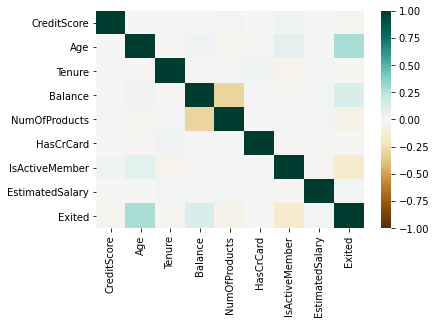

In [10]:
corr = data.corr()
sns.heatmap(corr, cmap='BrBG', vmax=1, vmin=-1)
plt.show()

Фичи между собой не коррелируют, выбросов нет

In [11]:
data['Tenure'].fillna(-1, inplace=True)

In [12]:
data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [13]:
object_columns = data.loc[:, data.dtypes == 'object'].columns
print(object_columns)

Index(['Geography', 'Gender'], dtype='object')


In [14]:
data.describe(include='object')

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


Количество уникальных категориальных признаков мало, поэтому можем применить OHE

In [15]:
for col in object_columns:
    dummies = pd.get_dummies(data[col], drop_first=True, prefix=col)
    data = pd.concat([data.drop(col, axis=1), dummies], axis=1)

data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Выводы:
- Данные не имели выбросов
- Не коррелировали между собой
- Категориальных признаков было мало, поэтому применим OHE
- Пропуск наблюдался только в одной колонке
- В исходных данных имелись лишние признаки

## Исследование задачи

In [16]:
X = data.drop('Exited', axis=1)
y = data['Exited']

In [17]:
y.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Имеем дисбаланс классов 1 к 4

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12345, stratify=y_train)

In [19]:
y_train.value_counts(normalize=True)

0    0.796267
1    0.203733
Name: Exited, dtype: float64

In [20]:
y_val.value_counts(normalize=True)

0    0.796267
1    0.203733
Name: Exited, dtype: float64

In [21]:
y_test.value_counts(normalize=True)

0    0.7964
1    0.2036
Name: Exited, dtype: float64

Пропорции дисбаланса в различных выборках сохранились

In [22]:
best_lr_model = None
best_param = 1
best_score = 0

for param in np.arange(0.1, 2, 0.1):
    lr_model = LogisticRegression(C=param)

    lr_model.fit(X_train, y_train)
    
    score = lr_model.score(X_train, y_train)
    
    if score > best_score:
        best_score = score
        best_lr_model = lr_model
        best_param = param
y_pred = best_lr_model.predict(X_val)

auc_score = roc_auc_score(y_val, best_lr_model.predict_proba(X_val)[:, 1])

print(f'Точность логистической регресии: {accuracy_score(y_val, y_pred):.3f}')
print(f'Параметр регуляризации C = : {best_param}')
print(f'AUC SCORE = {auc_score:.3f}')

Точность логистической регресии: 0.789
Параметр регуляризации C = : 0.1
AUC SCORE = 0.659


In [23]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1493
           1       0.39      0.07      0.12       382

    accuracy                           0.79      1875
   macro avg       0.60      0.52      0.50      1875
weighted avg       0.72      0.79      0.72      1875



In [24]:
best_param = None
best_dt_model = None
best_score = 0
for depth in range(1, 50):
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    dt_model.fit(X_train, y_train)
    score = dt_model.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_dt_model = dt_model
        best_param = depth

y_pred = best_dt_model.predict(X_val)

auc_score = roc_auc_score(y_val, best_dt_model.predict_proba(X_val)[:, 1])

print(f'Точность дерева решений: {accuracy_score(y_val, y_pred):.3f}')
print(f'Глубина дерева: {best_param}')
print(f'AUC SCORE = {auc_score:.3f}')

Точность дерева решений: 0.850
Глубина дерева: 6
AUC SCORE = 0.844


In [25]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1493
           1       0.75      0.39      0.51       382

    accuracy                           0.85      1875
   macro avg       0.81      0.68      0.71      1875
weighted avg       0.84      0.85      0.83      1875



Обучим сначала лес с небольшим количетсвом деревьев, подобрав глубину, найдем оптимальное кол-во деревьев

In [26]:
best_param_depth = None
best_param_est = None
best_rf_model = None
best_score = 0
for depth in range(1, 21):
    rf_model = RandomForestClassifier(n_estimators=10, max_depth=depth, random_state=12345)
    rf_model.fit(X_train, y_train)
    score = rf_model.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_param_depth = depth

for est in range(11, 100, 2):
    rf_model = RandomForestClassifier(n_estimators=est, max_depth=best_param_depth, random_state=12345)
    rf_model.fit(X_train, y_train)
    score = rf_model.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_rf_model = rf_model
        best_param_est = est

y_pred = best_rf_model.predict(X_val)

auc_score = roc_auc_score(y_val, best_rf_model.predict_proba(X_val)[:, 1])

print(f'Точность случайного леса: {accuracy_score(y_val, y_pred):.3f}')
print(f'Количество деревьев: {best_param_est}')
print(f'Глубина дерева: {best_param_depth}')

print(f'AUC SCORE = {auc_score:.3f}')

Точность случайного леса: 0.859
Количество деревьев: 39
Глубина дерева: 10
AUC SCORE = 0.850


Оценим адекватность моделей

In [27]:
y_pred = pd.Series(0, index=y_val)
print(f'Точность константой модели: {accuracy_score(y_val, y_pred):.3f}')

Точность константой модели: 0.796


Из за дисбаланса классов видим, что константная модель обладает такой же точностью, что и линейная

В качестве итоговой модели выберем случайный лес, так как он показал наибольшую точность на валидационной выборке

In [28]:
model = best_dt_model
y_pred = model.predict(X_val)

Выводы
- Лучшую точность показал случайны лес с точностью на валидационной выборке - 0.858
- Из-за дисбаланса классов требуется дополнительное исследование модели
- Линейная модель показала себя плохо, связано с тем, что у нас также невысокая кореляция с целевой переменной, а это плохо

## Борьба с дисбалансом

In [29]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1493
           1       0.75      0.39      0.51       382

    accuracy                           0.85      1875
   macro avg       0.81      0.68      0.71      1875
weighted avg       0.84      0.85      0.83      1875



Видим, что наша модель обладает низкой полнотой, что сказывается на f-score

Рассмотрим несколько способов борьбы с дисбалансом, а именно: upsample (downsample не подойдет так как у нас всего 10000 объектов в исходных данных),
подберем порог

In [30]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)

    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    return X_upsampled, y_upsampled

#не подойдет
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat([X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])

    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=12345)
    return X_downsampled, y_downsampled

Обучим заново случайный лес и найдем оптимальные гиперпараметры, в качестве параметра repeat возьмем 4, так как дисбаланс 1 к 4

In [31]:
best_param_depth = None
best_param_est = None
best_rf_model = None
best_score = 0

repeat = 4

X_upsampled, y_upsampled = upsample(X_train, y_train, repeat)

for depth in range(1, 21):
    dt_model = RandomForestClassifier(n_estimators=10, max_depth=depth, random_state=12345)
    dt_model.fit(X_upsampled, y_upsampled)
    score = dt_model.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_param_depth = depth

for est in range(10, 100, 1):
    dt_model = RandomForestClassifier(n_estimators=est, max_depth=best_param_depth, random_state=12345)
    dt_model.fit(X_upsampled, y_upsampled)
    score = dt_model.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_rf_model = dt_model
        best_param_est = est

y_pred = best_rf_model.predict(X_val)

print(f'Точность случайного леса: {accuracy_score(y_val, y_pred):.3f}')
print(f'Количество деревьев: {best_param_est}')
print(f'Глубина дерева: {best_param_depth}')

Точность случайного леса: 0.846
Количество деревьев: 65
Глубина дерева: 18


In [32]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.886     0.926     0.905      1493
           1      0.648     0.534     0.585       382

    accuracy                          0.846      1875
   macro avg      0.767     0.730     0.745      1875
weighted avg      0.837     0.846     0.840      1875



~~Требование f-score >= 0.59 - достигнуто~~ Уже не достигается, так как заменили медиану на -1 при заполнении пропусков, но через порог можно дойти

Подберем также порог

In [33]:
probabilities_valid = best_rf_model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]

In [34]:
for threshold in np.arange(0, 0.6, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_val, predicted_valid)
    recall = recall_score(y_val, predicted_valid)
    f1 = f1_score(y_val, predicted_valid)
    auc_score = roc_auc_score(y_val, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f-score = {:.3f}, roc-auc-score = {:.3f}".format(
        threshold, precision, recall, f1, auc_score))

Порог = 0.00 | Точность = 0.210, Полнота = 1.000, f-score = 0.346, roc-auc-score = 0.517
Порог = 0.01 | Точность = 0.213, Полнота = 1.000, f-score = 0.352, roc-auc-score = 0.528
Порог = 0.02 | Точность = 0.225, Полнота = 0.995, f-score = 0.367, roc-auc-score = 0.560
Порог = 0.03 | Точность = 0.228, Полнота = 0.995, f-score = 0.370, roc-auc-score = 0.565
Порог = 0.04 | Точность = 0.242, Полнота = 0.982, f-score = 0.388, roc-auc-score = 0.597
Порог = 0.05 | Точность = 0.254, Полнота = 0.976, f-score = 0.404, roc-auc-score = 0.622
Порог = 0.06 | Точность = 0.258, Полнота = 0.974, f-score = 0.408, roc-auc-score = 0.629
Порог = 0.07 | Точность = 0.270, Полнота = 0.961, f-score = 0.421, roc-auc-score = 0.647
Порог = 0.08 | Точность = 0.282, Полнота = 0.955, f-score = 0.435, roc-auc-score = 0.666
Порог = 0.09 | Точность = 0.285, Полнота = 0.953, f-score = 0.439, roc-auc-score = 0.670
Порог = 0.10 | Точность = 0.296, Полнота = 0.945, f-score = 0.451, roc-auc-score = 0.685
Порог = 0.11 | Точнос

~~При пороге 0.51 достигается максимальный f-score - 0.603~~ теперь при пороге 0.46 и максимальный f-score - 0.596

Построим ROC график

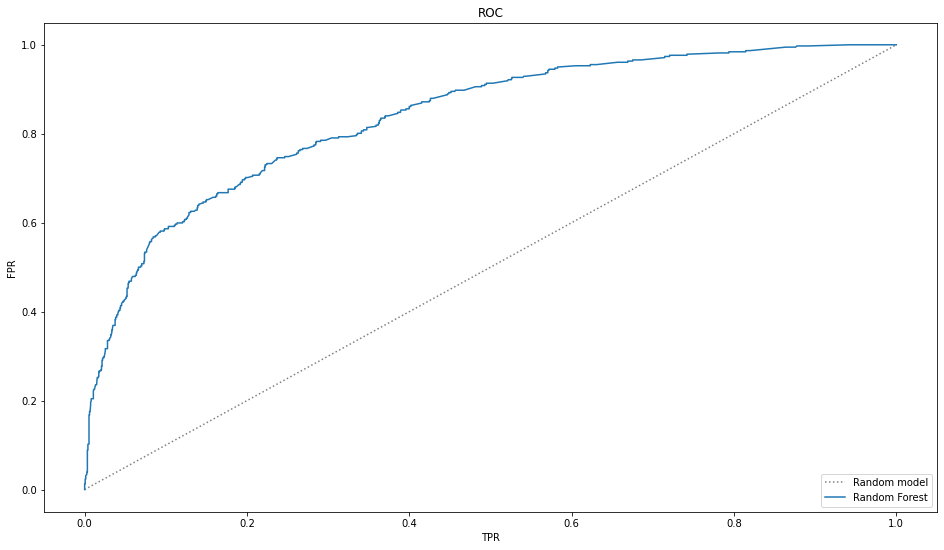

In [35]:
tpr, fpr, thresholds = roc_curve(y_val, probabilities_one_valid)

fig = plt.figure()

fig.set_size_inches(16, 9)

plt.plot([0, 1], ':', color='gray', label='Random model')
plt.plot(tpr, fpr, label='Random Forest')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')

plt.show()

Выводы:
- upsample помог увеличить f-score
- подбор порога показал меньший вклад, однако, если бы мы не применили upsample, то вклад от порога был бы существеннее
- Мы пожертвовали метрикой precision чтобы увеличить recall
- ROC-score 0.741

Рассмотрим в дополнении логистическую регрессию и решающее дерево

In [36]:
best_lr_model = None
best_param = 1
best_score = 0

repeat = 4

X_upsampled, y_upsampled = upsample(X_train, y_train, repeat)

for param in np.arange(0.1, 2, 0.1):
    lr_model = LogisticRegression(C=param)

    lr_model.fit(X_upsampled, y_upsampled)
    
    score = lr_model.score(X_train, y_train)
    
    if score > best_score:
        best_score = score
        best_lr_model = lr_model
        best_param = param
y_pred = best_lr_model.predict(X_val)

auc_score = roc_auc_score(y_val, best_lr_model.predict_proba(X_val)[:, 1])

print(f'Точность логистической регресии: {accuracy_score(y_val, y_pred):.3f}')
print(f'Параметр регуляризации C = : {best_param}')
print(f'AUC SCORE = {auc_score:.3f}')

Точность логистической регресии: 0.638
Параметр регуляризации C = : 0.1
AUC SCORE = 0.690


In [37]:
probabilities_one_valid = best_lr_model.predict_proba(X_val)[:, 1]

for threshold in np.arange(0, 0.6, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_val, predicted_valid)
    recall = recall_score(y_val, predicted_valid)
    f1 = f1_score(y_val, predicted_valid)
    auc_score = roc_auc_score(y_val, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f-score = {:.3f}, roc-auc-score = {:.3f}".format(
        threshold, precision, recall, f1, auc_score))

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.01 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.02 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.03 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.04 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.05 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.06 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.07 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.08 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.09 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.10 | Точность = 0.204, Полнота = 1.000, f-score = 0.339, roc-auc-score = 0.500
Порог = 0.11 | Точнос

При переборе порогов f-score выше 0.439 не поднимается

Теперь также с решающим деревом
Единственное, при использовании upsample в случае с деревом решений, f-score падает, поэтому repeat = 1

In [38]:
best_param = None
best_dt_model = None
best_score = 0


repeat = 1

X_upsampled, y_upsampled = upsample(X_train, y_train, repeat)

for depth in range(1, 100):
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    dt_model.fit(X_upsampled, y_upsampled)
    score = dt_model.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_dt_model = dt_model
        best_param = depth

y_pred = best_dt_model.predict(X_val)

auc_score = roc_auc_score(y_val, best_dt_model.predict_proba(X_val)[:, 1])

print(f'Точность дерева решений: {accuracy_score(y_val, y_pred):.3f}')
print(f'Глубина дерева: {best_param}')
print(f'AUC SCORE = {auc_score:.3f}')

Точность дерева решений: 0.850
Глубина дерева: 6
AUC SCORE = 0.844


In [39]:
probabilities_one_valid = best_dt_model.predict_proba(X_val)[:, 1]

for threshold in np.arange(0, 0.6, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_val, predicted_valid)
    recall = recall_score(y_val, predicted_valid)
    f1 = f1_score(y_val, predicted_valid)
    auc_score = roc_auc_score(y_val, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f-score = {:.3f}, roc-auc-score = {:.3f}".format(
        threshold, precision, recall, f1, auc_score))

Порог = 0.00 | Точность = 0.205, Полнота = 0.995, f-score = 0.340, roc-auc-score = 0.504
Порог = 0.01 | Точность = 0.205, Полнота = 0.995, f-score = 0.340, roc-auc-score = 0.504
Порог = 0.02 | Точность = 0.245, Полнота = 0.987, f-score = 0.392, roc-auc-score = 0.604
Порог = 0.03 | Точность = 0.245, Полнота = 0.987, f-score = 0.392, roc-auc-score = 0.604
Порог = 0.04 | Точность = 0.245, Полнота = 0.982, f-score = 0.392, roc-auc-score = 0.604
Порог = 0.05 | Точность = 0.245, Полнота = 0.982, f-score = 0.392, roc-auc-score = 0.604
Порог = 0.06 | Точность = 0.260, Полнота = 0.974, f-score = 0.410, roc-auc-score = 0.632
Порог = 0.07 | Точность = 0.268, Полнота = 0.971, f-score = 0.420, roc-auc-score = 0.646
Порог = 0.08 | Точность = 0.316, Полнота = 0.916, f-score = 0.470, roc-auc-score = 0.705
Порог = 0.09 | Точность = 0.419, Полнота = 0.814, f-score = 0.553, roc-auc-score = 0.762
Порог = 0.10 | Точность = 0.427, Полнота = 0.806, f-score = 0.558, roc-auc-score = 0.764
Порог = 0.11 | Точнос

Альтернативные модели не смогли достичь f-score >= 0.5

## Тестирование модели

In [40]:
threshold = 0.51 # получили при подборе

y_pred_test = (best_rf_model.predict_proba(X_test)[:, 1] > threshold)

print(f'Точность модели на тестовой выборке {accuracy_score(y_test, y_pred_test)}')

Точность модели на тестовой выборке 0.8544


In [41]:
print(classification_report(y_test, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.891     0.931     0.911      1991
           1      0.673     0.554     0.608       509

    accuracy                          0.854      2500
   macro avg      0.782     0.743     0.759      2500
weighted avg      0.847     0.854     0.849      2500



Выводы
- Точность модели с учетом порога составляет 0.95
- Требованние к f-score также достигнуто

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*